In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
import matplotlib as mpl


Top 25 countries, Avg. ratio across: 1.233, Median ratio: 1.032


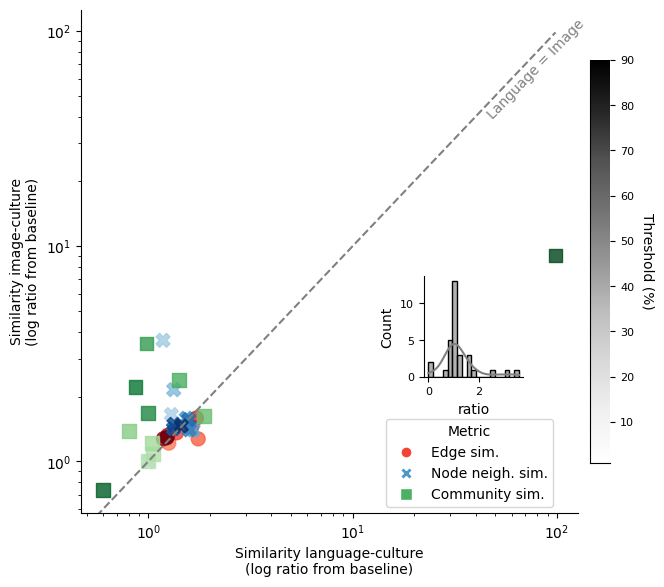

Top 50 countries, Avg. ratio across: 1.958, Median ratio: 1.174


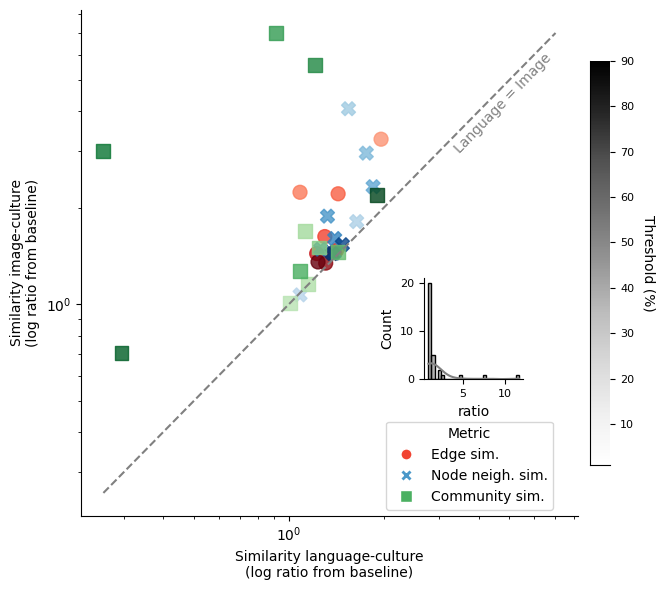

Top 100 countries, Avg. ratio across: 2.079, Median ratio: 1.446


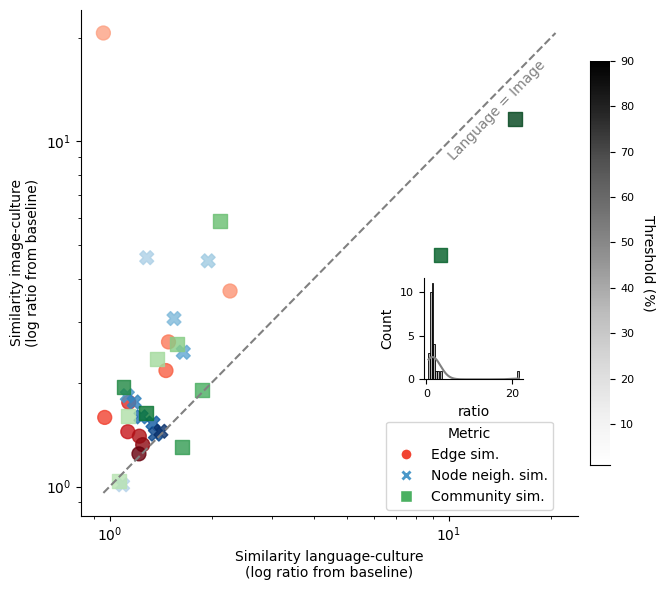

In [14]:
metrics = ["edge_jaccard", "node_jaccard", "community"]
metric_labels = ["Edge sim.", "Node neigh. sim.", "Community sim."]
n_thresholds_list = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for top_countries in [25, 50, 100]:

    # Collect results into a long dataframe
    all_results = []

    for threshold in n_thresholds_list:
        df = pd.read_csv(f"../data/comparison_culture_networks_top{threshold}_topcountries{top_countries}.csv")
        
        df_sample = df[df["dimension"] == "all"][[
            f"{m}_culture_image" for m in metrics
        ] + [
            f"{m}_culture_language" for m in metrics
        ]+ [
            f"{m}_image_null" for m in metrics
        ]+ [
            f"{m}_language_null" for m in metrics
        ]
        ]

        #replace 0s with small value to avoid division by zero
        for m in metrics:
            df_sample[f"{m}_image_null"] = df_sample[f"{m}_image_null"].replace(0, 1e-10)
            df_sample[f"{m}_language_null"] = df_sample[f"{m}_language_null"].replace(0, 1e-10)
        
        # Convert to long format
        for m, label in zip(metrics, metric_labels):
            all_results.append(pd.DataFrame({
                "Metric": label,
                "image_lift": (df_sample[f"{m}_culture_image"]) / (df_sample[f"{m}_image_null"]),
                "language_lift": (df_sample[f"{m}_culture_language"])/ (df_sample[f"{m}_language_null"]),
                "Threshold": threshold * 100,  # convert to %
                "image-culture_metric": df_sample[f"{m}_culture_image"],
                "language-culture_metric": df_sample[f"{m}_culture_language"],
                "image-null_metric": df_sample[f"{m}_image_null"],
                "language-null_metric":  df_sample[f"{m}_language_null"],
            }))

    plot_df = pd.concat(all_results)
    plot_df["ratio"] = plot_df["image_lift"] / plot_df["language_lift"]

    # print(top_countries)
    #print(plot_df)
    # print()

    # remove outliers for better visualization (and to avoid computational issues)
    plot_df = plot_df[(plot_df["language_lift"] < 5000) & (plot_df["image_lift"] < 5000)]

    plt.figure(figsize=(7, 6))
    ax = plt.gca()

    metric_cmaps = {
        "Edge sim.": plt.cm.Reds,
        "Node neigh. sim.": plt.cm.Blues,
        "Community sim.": plt.cm.Greens
    }

    metric_markers = {
        "Edge sim.": "o",
        "Node neigh. sim.": "X",
        "Community sim.": "s"
    }

    # Normalization object (shared for all metrics)
    norm = plt.Normalize(vmin=min(n_thresholds_list) * 100, vmax=max(n_thresholds_list) * 100)

    for metric, cmap in metric_cmaps.items():
        subset = plot_df[plot_df["Metric"] == metric]
        colors = cmap(0.3 + 0.7 * norm(subset["Threshold"]))  # color mapping
        plt.scatter(
            subset["language_lift"],
            subset["image_lift"],
            color=colors,
            s=100,
            label=metric,
            marker=metric_markers[metric],
            alpha=0.8,
        )

        plt.xscale('log')
        plt.yscale('log')

    # === Add GREYSCALE colorbar representing Thresholds ===
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Greys, norm=norm)
    sm.set_array([])

    cbar = plt.colorbar(sm, ax=ax, pad=0.02, shrink=0.8, location="right")
    cbar.set_label("Threshold (%)", rotation=270, labelpad=15)
    cbar.ax.tick_params(labelsize=8)
    cbar.outline.set_visible(False)

    # === Diagonal and labels ===
    lims = [
        min(plot_df["language_lift"].min(), plot_df["image_lift"].min()),
        max(plot_df["language_lift"].max(), plot_df["image_lift"].max())
    ]
    plt.plot(lims, lims, color="gray", linestyle="--")

    x_pos = lims[1] - 0.55 * (lims[1] - lims[0])
    y_pos = x_pos - 0.05 * (lims[1] - lims[0])
    plt.text(x_pos, y_pos, "Language = Image", color='gray', fontsize=10, rotation=46)

    plt.xlabel("Similarity language-culture\n(log ratio from baseline)")
    plt.ylabel("Similarity image-culture\n(log ratio from baseline)")

    # === Legend for metrics ===
    marker_legend = [
        Line2D(
            [0], [0],
            marker=metric_markers[m],
            color='w',
            label=m,
            markerfacecolor=metric_cmaps[m](0.6),
            markersize=8
        )
        for m in metric_cmaps
    ]
    plt.legend(handles=marker_legend, title="Metric", bbox_to_anchor=(0.60, 0.2), loc='upper left')

    plt.tight_layout()
    sns.despine()

    # === Inset histogram ===
    ax_inset = inset_axes(
        plt.gca(),
        width="20%",
        height="20%",
        loc="upper left",
        bbox_to_anchor=(0.69, -0.53, 1, 1),
        bbox_transform=plt.gca().transAxes,
        borderpad=0
    )
    sns.histplot(plot_df["ratio"], kde=True, ax=ax_inset, color="grey", alpha=0.6)
    ax_inset.tick_params(axis="both", labelsize=8)
    sns.despine(ax=ax_inset)
    mean_ratio = plot_df["ratio"].mean()
    print(f"Top {top_countries} countries, Avg. ratio across: {mean_ratio:.3f}, Median ratio: {plot_df['ratio'].median():.3f}")

    plt.savefig(f"../plots_downstream/clusterability_top{top_countries}_culture_networks.pdf")
    plt.show()
    plt.close()
